In [1]:
import datetime, urllib, re, math, json, requests,io
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML



try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))

In [2]:
#** pandas
# change max number of rows to show
pd.set_option('display.max_rows', 300)

#** plotters formats

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from cycler import cycler
#* dpi size
plt.rcParams['figure.dpi'] = 200
myFmt = mdates.DateFormatter('%m/%d')
myLocator = mticker.MultipleLocator(7)

default_cycler = (cycler(marker=['.','*','+','s','x']) *
                  cycler(color=['b','g','k','m','y','c','r']) *
                  cycler(linestyle=['-']))

plt.rc('axes', prop_cycle=default_cycler)

#** panda data frame styles
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


In [209]:
df = pd.read_csv("https://coronadatascraper.com/timeseries-tidy.csv")
df.fillna("NA",inplace=True);
dataTCS =df.set_index(["city","county","state","country","type"])
dataTCS["date"] = [datetime.datetime.strptime(ts,"%Y-%m-%d").date() for ts in dataTCS["date"]]


In [305]:
def plotter(minCount=5000,minCountKpi="cases",equalize=True,equalizeTrg="ITA",equalizeCount=100, plotKpi="deaths",logyPlot=True):
    idx = pd.IndexSlice


    fig,ax = plt.subplots(1,1)

    if(equalize):
        g = dataTCS.loc[idx["NA","NA","NA",equalizeTrg,minCountKpi]]
        gdts = g[g["value"]>100]["date"].values[0]

        print(gdts)

    idxScreen = lambda ctr :idx["NA","NA","NA",ctr,minCountKpi];
    idxPlot   = lambda ctr :idx["NA","NA","NA",ctr,plotKpi];
    # temp commented out    
    for ctr in dataTCS.index.levels[3]:    
        if dataTCS.loc[idxScreen(ctr)].value[-1]< minCount: continue     
        g = dataTCS.loc[idxPlot(ctr),["date","value"]]        
        if(equalize):
            #check if sufficent samples exist to equlize
            if False == (g["value"]>equalizeCount).any(): continue
            dts = g[g["value"]>equalizeCount]["date"].values[0]
            print("%s --> %d" %(ctr,(dts-gdts).days))
            data= g[g["date"]>=dts]
            ts = [(gdts + datetime.timedelta(i)) for i in range(0,sp.size(data["value"]))] 
        else:
            ts=g.index
            data=g["value"]
        ax.plot_date(ts,data["value"].values,label=ctr)    
    ax.xaxis.set_major_locator(myLocator)
    ax.grid()
    ax.xaxis.set_major_formatter(myFmt)
    ax.legend()
    ax.set_title("new cases vs time");

    if(logyPlot) : plt.yscale('log')

In [308]:
from IPython.html.widgets import *


interact(plotter,minCount=(0,1e6),
         minCountKpi=dataTCS.index.levels[4].unique().values,
         equalize=[True, False],
         equalizeTrg=dataTCS.index.levels[3].unique().values,
         equalizeCount=(0,10000),
         plotKpi=dataTCS.index.levels[4].unique().values,
         logyPlot=[True, False])

interactive(children=(FloatSlider(value=5000.0, description='minCount', max=1000000.0), Dropdown(description='…

<function __main__.plotter(minCount=5000, minCountKpi='cases', equalize=True, equalizeTrg='ITA', equalizeCount=100, plotKpi='deaths', logyPlot=True)>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.


2020-02-24
BEL --> 29
CHE --> 28
CHN --> -27
DEU --> 29
ESP --> 18
FRA --> 21
GBR --> 24
IRN --> 10
ITA --> 9
KOR --> 26
NLD --> 25
PRT --> 34
TUR --> 33
USA --> 22


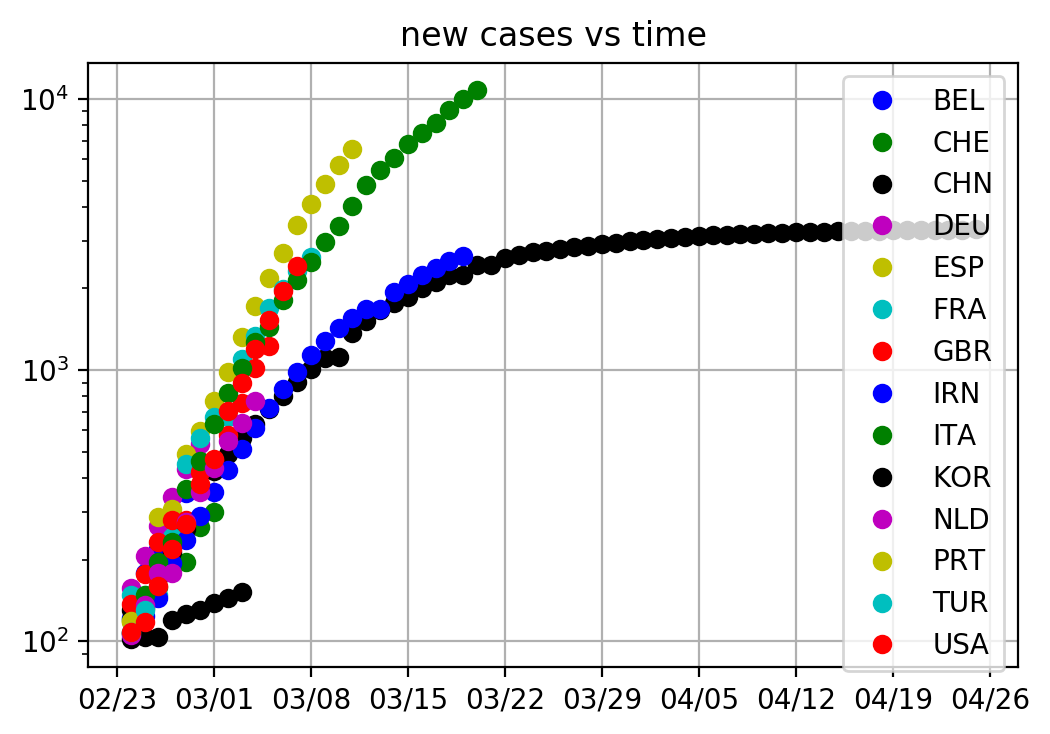

In [291]:
# country screen
minCount     = 5000
minCountKpi  = "cases" # 'active', 'cases', 'deaths', 'growthFactor', 'recovered', 'tested'
# Equalize (kpi same as plot)
equalize     = True
equalizeTrg  = "ITA"
equalizeCount= 100

# plot 
plotKpi      = "deaths"
logyPlot     = True
plotter(minCount,minCountKpi,equalize,equalizeTrg,equalizeCount, plotKpi,logyPlot)